## Coin market price prediction and visualizations.

### Project Overvew:¶
The <b>goal</b> of this project is to build high accuracy model for price prediction.
For this project, I will use my 6 favourite coins. Code in this notebook is a partially scalable list of coins, the period of data collection and price prediction is up to the user. 
<img src="coins.jpg" alt="Coins" width="500" height="600">

The first task is to collect current coin data from yahoo finance using yahoo API<br> I going to focus on the last 2 year period. I will provide important coin statistics that will give useful information about each coin project In the next step I will create useful visualisations for close day prices and price changes.<br>
I will use investigate how correlated prices are for my coins. 
My visualisation list for all coins for the last 2 years :
1. Plot daily close price.
2. Plot daily training volume.
3. Plot daily price volatility in percentage.
4. Add moving average for 20, 50, 200 days and plot the with closing price.
5. The subplot of similarity between coins for price close.
6. Heatmap for coins correlation matrix for price close
7. The subplot of similarity between coins for price volatility.
8. Heatmap for coins correlation matrix for price volatility.
9. Plot the full historical price for the chosen coin.
10. Final model price prediction plot

To build my coin price prediction model I will use Keras Sequential model with a Long Short-Term Memory, Dense and Dropout layers.
To run my project I will use python libraries listed:  pandas, numpy, matplotlib, seaborn, keras, yfinance, yahoofinancials


<b>To learn about finance libraries used in this project check links:</b><br> 
<a> href="https://pypi.org/project/yfinance/">Yahoo finance project</a><br> 
To instal library Yfinance in terminal use:<br> 
$ pip install yfinance</br></b>

<a> href="https://pypi.org/project/yahoofinancials/">YahooFinancials</a><br>
To instal library YahooFinancials in terminal use:<br> 
$ pip install yahoofinancials


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#Yahoo tools
import yfinance as yf
from yahoofinancials import YahooFinancials

# Model tools
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


### Load data from Yahoo Finance

In [2]:
# Create coins list to download data from yahoo finance. 
coin_ticker = ['BTC-USD', 'ETH-USD', 'XTZ-USD', 'XRP-USD', 'DOT1-USD', 'SOL1-USD'] # Number of Tickers need to be even  

In [3]:
"""Yahoo provide dictionary that include lots of finantial information for each coin. 
This cell might run for few seconds with more coins/assets)"""
# Collect summary information for coins
yahoo_financials = YahooFinancials(coin_ticker)
data=yahoo_financials.get_summary_data()

# Show the most interesting coin statistic
df_summary = pd.DataFrame(data=data)
df_summary.loc[['startDate', 'marketCap', 'circulatingSupply', 'maxSupply', 'volume', 'averageDailyVolume10Day','averageVolume','open', 'fiftyTwoWeekHigh','fiftyTwoWeekLow']]

,BTC-USD,ETH-USD,XTZ-USD,XRP-USD,DOT1-USD,SOL1-USD
startDate,2013-04-28,2015-08-07,2017-10-06,2013-08-04,2020-08-19,2020-04-10
marketCap,1127583711232,503457415168,4402202624,52356509696,40668180480,64607649792
circulatingSupply,18876550,118388744,867424512,47158976512,987579328,303507360
maxSupply,None,None,None,None,None,None
volume,37247750144,18855661568,186304512,4819757568,1788375936,2727083264
averageDailyVolume10Day,37464375073,18827360372,237491541,4455806633,1899507641,2861441026
averageVolume,36044487610,19613227684,629517977,4329770216,2308923397,3786568615
open,60240.53,4279.3066,5.208469,1.092907,42.53208,217.88876
fiftyTwoWeekHigh,68789.625,4891.7046,9.175448,1.964997,55.004974,260.0621
fiftyTwoWeekLow,16351.035,465.70425,1.644792,0.174831,4.459481,1.090161


In [4]:
#Set period for  data collection (last 2 years)
period = '2y'

# Function that will create dataframe for chosed coins
df_list = list()
for ticker in coin_ticker:
    data = yf.download(ticker, group_by="Ticker", period=period)
    data['coin_ticker'] = ticker  
    df_list.append(data)
    
    

# Combine data into a single dataframe
df = pd.concat(df_list)

# Save df to csv
basename = "coins"
suffix = datetime.now().strftime("%y%m%d_%H%M%S")
filename = "_".join([basename, suffix])
df.to_csv(filename)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Data pre-processing

In [5]:
# Print df shape
print(f'Data frame include: {df.shape[0]} lines in columns: {df.shape[1]}')

# Print first 3 lines of df
df.head(3) 

Data frame include: 3905 lines in columns: 7


,Open,High,Low,Close,Adj Close,Volume,coin_ticker
Date,,,,,,,
2019-11-18,8573.980469,8653.280273,8273.573242,8309.286133,8309.286133,21579470673,BTC-USD
2019-11-19,8305.134766,8408.516602,8099.963379,8206.145508,8206.145508,21083613816,BTC-USD
2019-11-20,8203.613281,8237.240234,8010.511719,8027.268066,8027.268066,20764300437,BTC-USD


In [6]:
# Move coin ticker to the front of df
df = df[ ['coin_ticker'] + [ col for col in df.columns if col != 'coin_ticker' ]]


# Adding new columns Volume in Bilions, daily difference in value and procentage to support next visualisations
df['Volume_in_Bln'] = df['Volume']/1e9
df['daily_diff'] = (df['Close'] - df['Open'])
df['daily_proc_diff'] = ((df['Close'] / df['Open']))-1

df.tail()

,coin_ticker,Open,High,Low,Close,Adj Close,Volume,Volume_in_Bln,daily_diff,daily_proc_diff
Date,,,,,,,,,,
2021-11-14,SOL1-USD,241.862106,242.044891,230.689407,238.425522,238.425522,1705211600,1.705212,-3.436584,-0.014209
2021-11-15,SOL1-USD,238.731400,245.976105,235.099106,237.553604,237.553604,2414551003,2.414551,-1.177795,-0.004934
2021-11-16,SOL1-USD,238.497147,238.497147,215.442093,219.239029,219.239029,3557977024,3.557977,-19.258118,-0.080748
2021-11-17,SOL1-USD,219.295639,222.028839,210.026947,218.715240,218.715240,2982505239,2.982505,-0.580399,-0.002647
2021-11-18,SOL1-USD,217.888763,222.683594,211.848190,212.870132,212.870132,2727083264,2.727083,-5.018631,-0.023033


In [7]:
# Show df basic informations
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3905 entries, 2019-11-18 to 2021-11-18
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   coin_ticker      3905 non-null   object 
 1   Open             3905 non-null   float64
 2   High             3905 non-null   float64
 3   Low              3905 non-null   float64
 4   Close            3905 non-null   float64
 5   Adj Close        3905 non-null   float64
 6   Volume           3905 non-null   int64  
 7   Volume_in_Bln    3905 non-null   float64
 8   daily_diff       3905 non-null   float64
 9   daily_proc_diff  3905 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 335.6+ KB


## Visualizations
### 1. Plot daily close price.


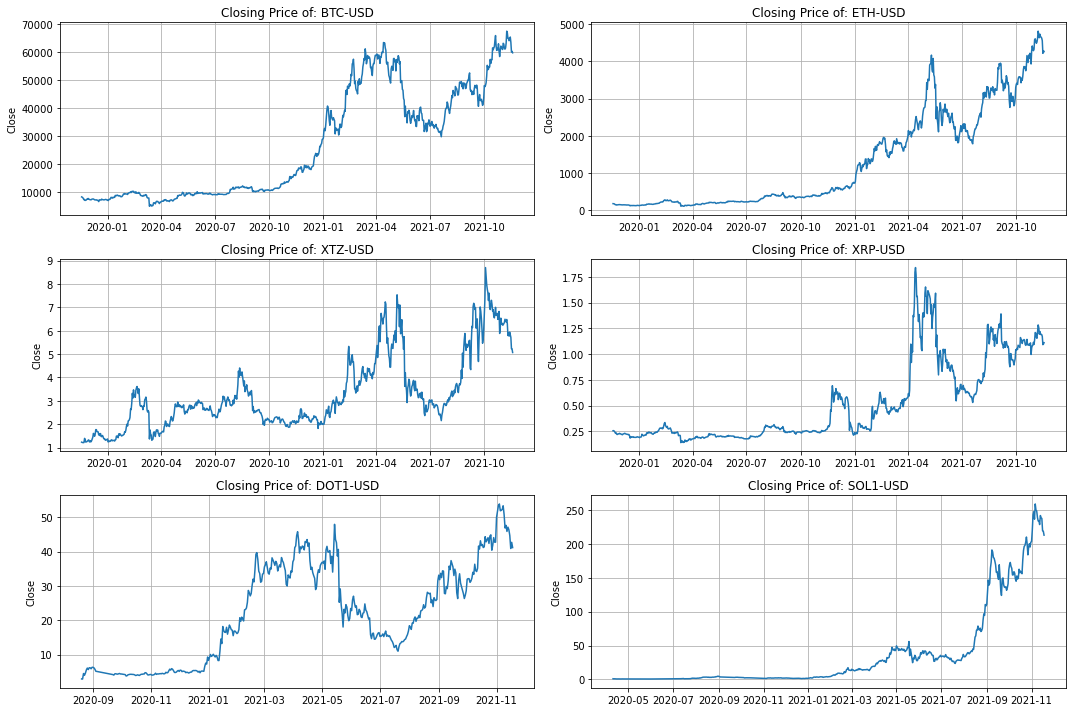

In [8]:
# Plot close price for all coins.
fig = plt.figure(figsize=(15, 10))

for c, num in zip(coin_ticker, range(1, len(coin_ticker)+1)):
    df1 = df[df['coin_ticker']==c]
    ax = fig.add_subplot(len(coin_ticker)/2, 2, num)
    ax.plot(df1['Close'])
    ax.set_title(f"Closing Price of: {c}")
    plt.ylabel('Close')
    plt.grid()
    
plt.tight_layout()
plt.show()

### 2. Plot daily training volume.


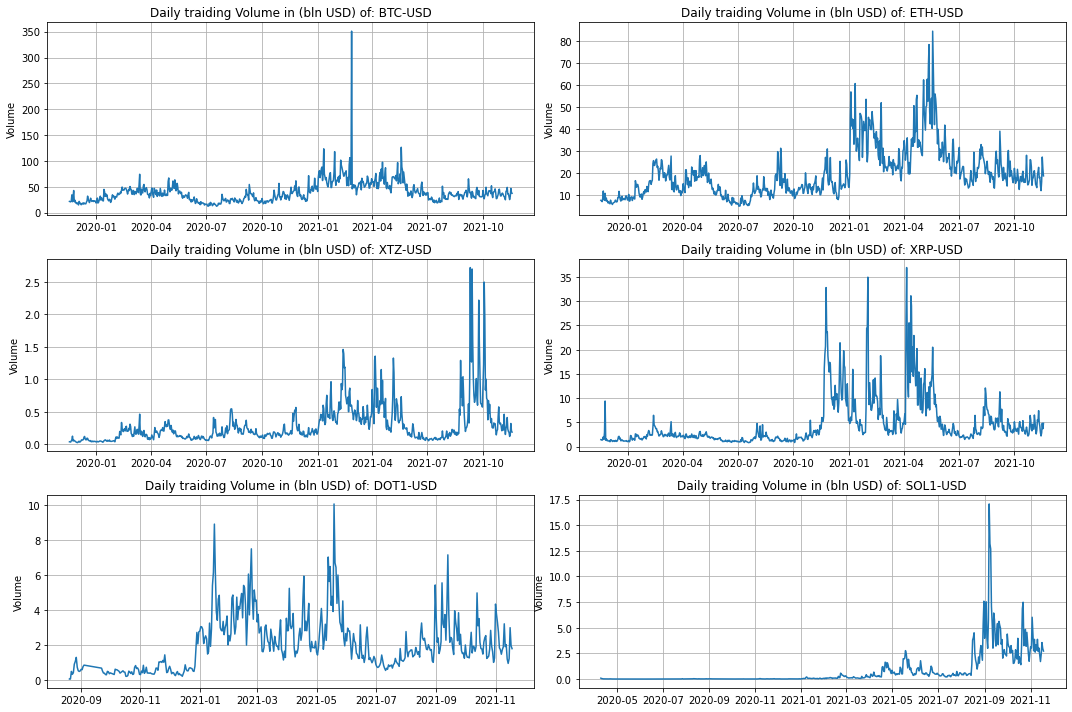

In [9]:
# Plot Volume for all coins. 
fig = plt.figure(figsize=(15, 10))

for c, num in zip(coin_ticker, range(1, len(coin_ticker)+1)):
    df1 = df[df['coin_ticker']==c]
    ax = fig.add_subplot(len(coin_ticker)/2, 2, num)
    ax.plot(df1['Volume_in_Bln'])
    ax.set_title(f"Daily traiding Volume in (bln USD) of: {c}")
    plt.ylabel('Volume')
    plt.grid()

plt.tight_layout()
plt.show()

### 3. Plot daily price volatility in percentage.

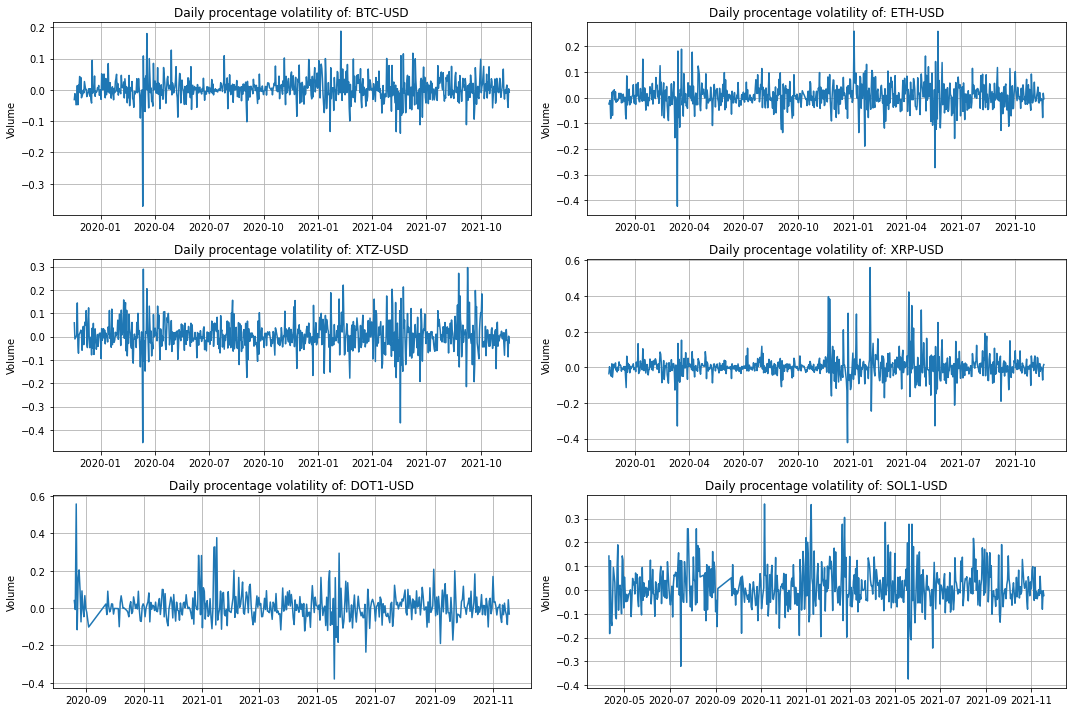

In [10]:
# Plot daily volatility for all coins. 
fig = plt.figure(figsize=(15, 10))

for c, num in zip(coin_ticker, range(1, len(coin_ticker)+1)):
    df1 = df[df['coin_ticker']==c]
    ax = fig.add_subplot(len(coin_ticker)/2, 2, num)
    ax.plot(df1['daily_proc_diff'])
    ax.set_title(f"Daily procentage volatility of: {c}")
    plt.ylabel('Volume')
    plt.grid()

plt.tight_layout()
plt.show()

In [11]:
# Show top 10 days for all coins profit
df.sort_values(by='daily_proc_diff', ascending = False).head(10)

,coin_ticker,Open,High,Low,Close,Adj Close,Volume,Volume_in_Bln,daily_diff,daily_proc_diff
Date,,,,,,,,,,
2021-01-30,XRP-USD,0.282152,0.489346,0.279825,0.440244,0.440244,24417465997,24.417466,0.158092,0.560308
2020-08-22,DOT1-USD,2.878570,4.510613,2.816762,4.484690,4.484690,485801096,0.485801,1.606120,0.557958
2021-04-05,XRP-USD,0.646703,0.936855,0.633974,0.920473,0.920473,26415199263,26.415199,0.273770,0.423332
2020-11-21,XRP-USD,0.328068,0.463057,0.328068,0.458344,0.458344,16206296041,16.206296,0.130276,0.397101
2020-11-23,XRP-USD,0.443701,0.614969,0.434732,0.613980,0.613980,20715303968,20.715304,0.170279,0.383770
2021-01-16,DOT1-USD,13.198050,19.322062,13.185754,18.180424,18.180424,8917081506,8.917082,4.982374,0.377508
2020-11-06,SOL1-USD,1.405218,1.940707,1.400011,1.913740,1.913740,22547497,0.022547,0.508522,0.361881
2021-01-08,SOL1-USD,2.368740,3.779320,2.180929,3.219887,3.219887,206412154,0.206412,0.851147,0.359325
2021-04-10,XRP-USD,1.020282,1.389957,1.008636,1.374416,1.374416,25547794935,25.547795,0.354134,0.347094


In [12]:
# Show top 10 days for all coins loses.
df.sort_values(by='daily_proc_diff').head(10)

,coin_ticker,Open,High,Low,Close,Adj Close,Volume,Volume_in_Bln,daily_diff,daily_proc_diff
Date,,,,,,,,,,
2020-03-12,XTZ-USD,2.509758,2.510685,1.364065,1.368093,1.368093,281543680,0.281544,-1.141665,-0.454890
2020-03-12,ETH-USD,194.738922,195.147934,111.210709,112.347122,112.347122,22134741655,22.134742,-82.391800,-0.423089
2020-12-23,XRP-USD,0.447966,0.447966,0.221363,0.258602,0.258602,19793483656,19.793484,-0.189364,-0.422720
2021-05-19,DOT1-USD,40.688820,41.340519,18.635315,25.227142,25.227142,10069997172,10.069997,-15.461678,-0.379998
2021-05-19,SOL1-USD,56.089256,57.525772,29.429859,35.107182,35.107182,2772224999,2.772225,-20.982075,-0.374084
2020-03-12,BTC-USD,7913.616211,7929.116211,4860.354004,4970.788086,4970.788086,53980357243,53.980357,-2942.828125,-0.371869
2021-05-19,XTZ-USD,5.745758,5.838486,2.888095,3.618687,3.618687,731846127,0.731846,-2.127071,-0.370199
2020-03-12,XRP-USD,0.208205,0.209124,0.139635,0.139635,0.139635,3547958418,3.547958,-0.068570,-0.329339
2021-05-19,XRP-USD,1.593270,1.644380,0.875318,1.070313,1.070313,20523476458,20.523476,-0.522957,-0.328229


In [13]:
# Calculate Moving averages 20, 50, 200 days for close price 
ma_days = [20, 50, 200]

for ma in ma_days:
    column_name = f"MA for {ma} days"
    df[column_name] = df.groupby('coin_ticker')['Close'].transform(lambda x: x.rolling(ma).mean()-x.iat[0])     

### 4. Plot moving average for 20, 50, 200 days and  closing price.

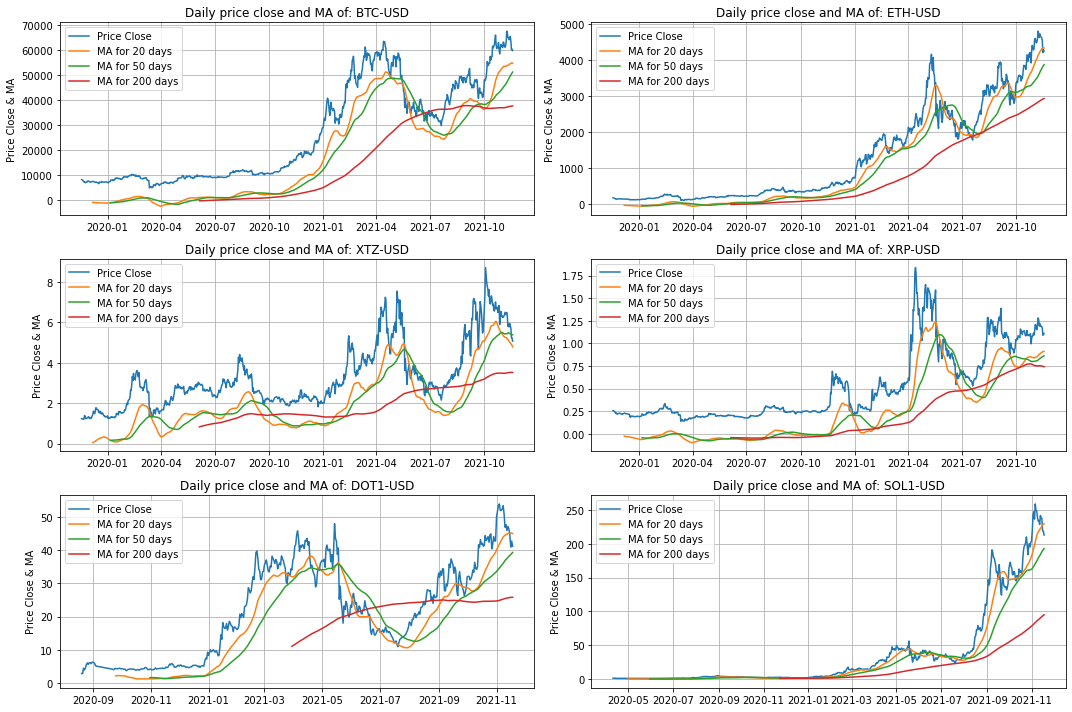

In [14]:
# Plot  price close and moving averages for coins
fig = plt.figure(figsize=(15, 10))

for c, num in zip(coin_ticker, range(1, len(coin_ticker)+1)):
    df1 = df[df['coin_ticker']==c]
    ax = fig.add_subplot(len(coin_ticker)/2, 2, num)
    ax.plot(df1[['Close', 'MA for 20 days', 'MA for 50 days', 'MA for 200 days' ]])
    ax.set_title(f'Daily price close and MA of: {c}')
    plt.ylabel('Price Close & MA')
    ax.legend(['Price Close', 'MA for 20 days', 'MA for 50 days', 'MA for 200 days'])
    plt.grid()

plt.tight_layout()
plt.show()

In [15]:
# Transform data frame to calculate correlation betwen coins
close_df = df.loc[:, ['coin_ticker', 'Close']]
close_df = pd.pivot_table(close_df, values='Close', index='Date', columns = 'coin_ticker')

# Let's take a quick look
close_df.head(3)

coin_ticker,BTC-USD,DOT1-USD,ETH-USD,SOL1-USD,XRP-USD,XTZ-USD
Date,,,,,,
2019-11-18,8309.286133,NaN,180.559601,NaN,0.255653,1.232249
2019-11-19,8206.145508,NaN,177.455551,NaN,0.256500,1.219358
2019-11-20,8027.268066,NaN,175.698349,NaN,0.251364,1.213215


### 5. The subplot of similarity between coins for price close.

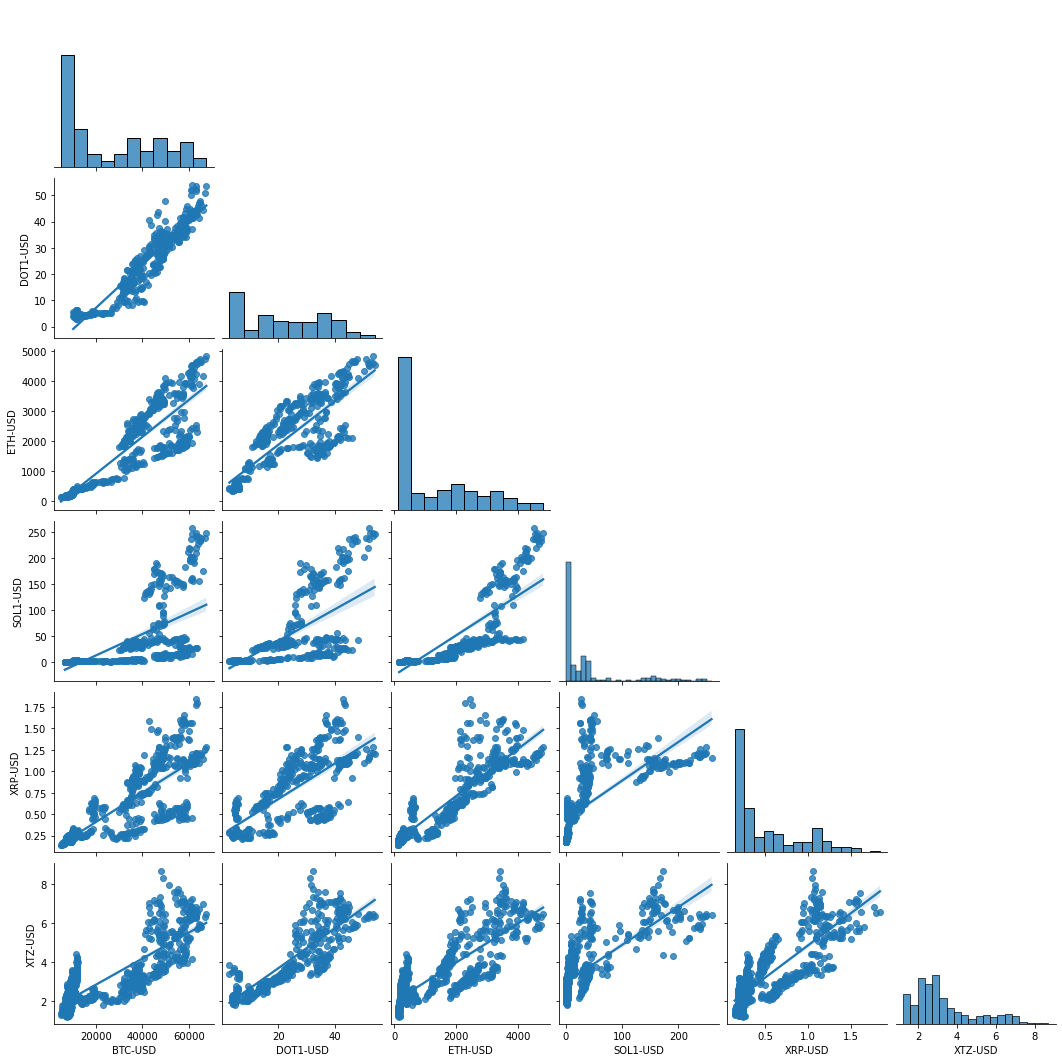

In [16]:
# Show Pairplot visualizes to find the similarity between coins
sns.pairplot(close_df, kind='reg', corner=True)

<br>Plot analysis:</br> The end day price for some of the coins are showing quite strong linear relations. This can be observed for BTC and DOT, BTC and ETR, ETH and DOT, XRP and ETR. Solana is very different as price shows more exponential growth. XRP after exponential growth price dropped and is now slowly moving up sideways.

### 6. Heatmap for coins correlation matrix for price close

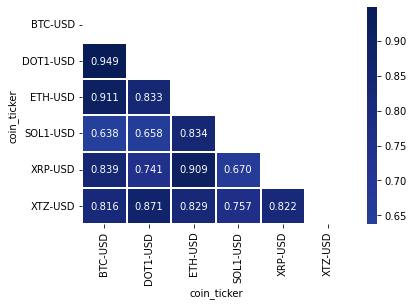

In [17]:
# Create the correlation matrix for numerical values in DF.
corr = close_df.corr()

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool)) # - mask reduce duplication on chart its more readable

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, center=0, linewidths=2, cmap="YlGnBu", annot=True, fmt=".3f")
plt.show()

<br>Heatmap analysis:</br>All coins end day close prices are correlated above 60%. Very interesting correlations above 90% are between BTC and DOT and ETH, another interesting is a correlation between ETH and XRP. This correlation strongly suggests that those cons prices follow each other. We already know that the biggies market cap coin is BTC and apart from SOL coin rest coins are correlated above 80%. That suggests that BTC is leading this con group.

#lets do this for price difference %

In [18]:
# Transform data frame to calculate correlation betwen coins
daily_proc_df = df.loc[:, ['coin_ticker', 'daily_proc_diff']]
daily_proc_df = pd.pivot_table(daily_proc_df, values='daily_proc_diff', index='Date', columns = 'coin_ticker')

# Let's take a quick look
daily_proc_df.head(3)

coin_ticker,BTC-USD,DOT1-USD,ETH-USD,SOL1-USD,XRP-USD,XTZ-USD
Date,,,,,,
2019-11-18,-0.030872,NaN,-0.024221,NaN,-0.035770,0.058857
2019-11-19,-0.011919,NaN,-0.016880,NaN,0.003341,-0.010461
2019-11-20,-0.021496,NaN,-0.009677,NaN,-0.020195,-0.005038


### 7. The subplot of similarity between coins for price volatility.

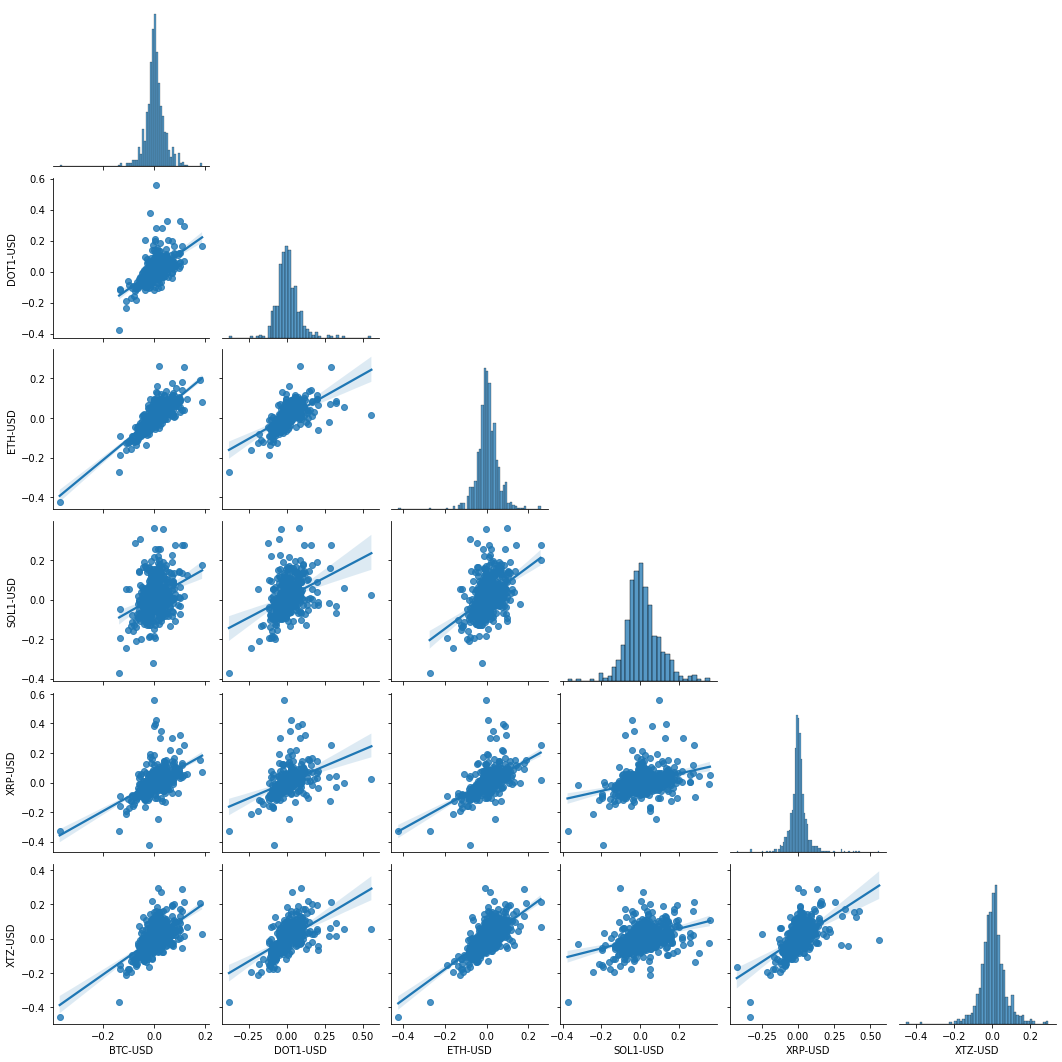

In [19]:
# Show Pairplot visualizes to find the similarity between coins
sns.pairplot(daily_proc_df, kind='reg', corner=True)

<br>Plot analysis:</br>The majority daily percentage price difference between price open and close are range -20% to +20%. There is also a very high concentration for price change between -10% to +10%. This price difference is what all coin investors should accept and be prepared for. The distribution plot drawn to show the marginal distribution for all coins daily prices change is revealing normal distribution. They are significantly high outliers that also showing how strong price changes we can observe -40% 0r +40% . These we call game-changer days but they are quite rare to observe. Some of the coins are exhibit a stronger relationship between their prices daily change BTC and ETH, also XTZ and ETH, XRP and ETH

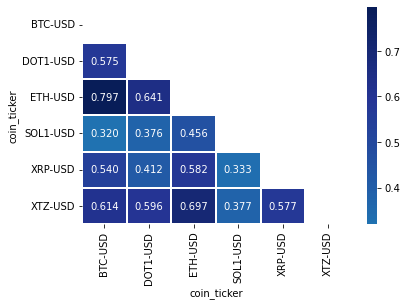

In [20]:
# Create the correlation matrix for numerical values in DF.
corr = daily_proc_df.corr()

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(corr, dtype=bool)) # - mask reduce duplication on chart its more readable

# Add the mask to the heatmap
sns.heatmap(corr, mask=mask, center=0, linewidths=2, cmap="YlGnBu", annot=True, fmt=".3f")
plt.show()

### 8. Heatmap for coins correlation matrix for price volatility.


<br>Heatmap analysis:</br>The daily procentage price difference is showing lower correltationthen end price betwen the coins. There are few already noticed on pari plots that showing strong correlation BTC and ETH - 79.7%, anotherintresting pair is ETH and XTZ - 69.5%, the last one ETH and DOT - 64% 

## Stock price prediction LSTM model

In [180]:
# Create coin object using yahoo asset ticker
coin = 'XTZ'# Use any of coin/assets ticker to run price prediction
currency = 'USD'
coin = (f'{coin}-{currency}')

# Adjust start date for collecion of data from yahoo to first day of coin on yahoo
start_df = df_summary.loc[['startDate']]
start = str(start_df.iloc[0][coin])

data = yf.download(coin, start='2012-04-28', end=datetime.now())

# Create data frame
df = data

# save to csv
basename = (f'coin{coin}')
suffix = datetime.now().strftime("%y%m%d_%H%M%S")
filename = "_".join([basename, suffix])
df.to_csv(filename)


[*********************100%***********************]  1 of 1 completed


### 9. Full historical price plot for the coin.

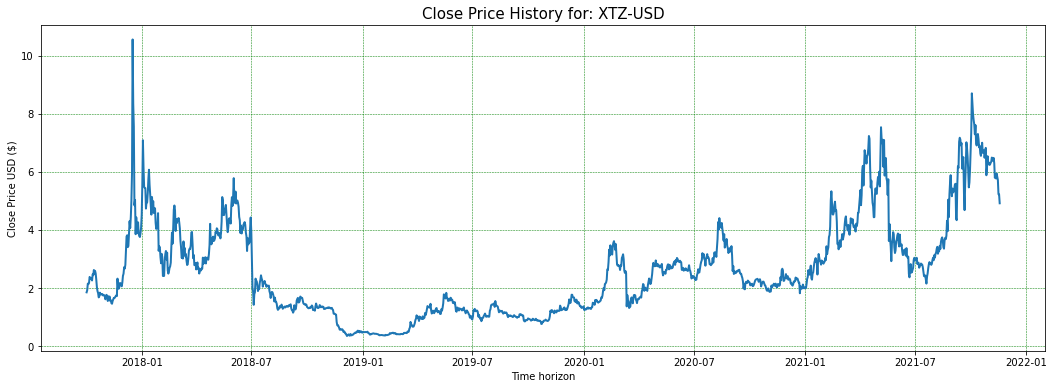

In [181]:
# Plot price close for coin
plt.figure(figsize=(18,6))
plt.title(f'Close Price History for: {coin}', fontsize=15)
plt.plot(df['Close'], linewidth = 2)
plt.xlabel('Time horizon', fontsize=10)
plt.ylabel('Close Price USD ($)', fontsize=10)
plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)

plt.show()

In [182]:
# Create a new dataframe with only the Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values

# Get the 80% number of rows to train the model.
training_data_len = int(np.ceil(len(dataset) * .80 ))

print(f'Total number of Price close in data:    {len(data)}')
print(f'The number of Price close for training: {training_data_len}')
print(f'The number of Price close for test:     {len(data) - training_data_len}')

Total number of Price close in data:    1505
The number of Price close for training: 1204
The number of Price close for test:     301


In [183]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [184]:
# Create the training data set 
train_data = scaled_data[0:int(training_data_len), :]

# Split the data into x_train and y_train data sets
x_train, y_train = [], []

# Create prediction window
pred_days = 80

for x in range(pred_days, len(train_data)):
    x_train.append(train_data[x-pred_days:x, 0])
    y_train.append(train_data[x, 0])
    if x <= int(pred_days +1):
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.14718836, 0.15434405, 0.17650462, 0.17489325, 0.17890357,
       0.19911579, 0.19575886, 0.19272123, 0.19305625, 0.18720926,
       0.2080631 , 0.20487658, 0.22244206, 0.21034353, 0.21972868,
       0.21057273, 0.18950828, 0.16447662, 0.15126038, 0.14451318,
       0.13014109, 0.13398683, 0.14610104, 0.14026875, 0.14102888,
       0.14012671, 0.14164307, 0.1367727 , 0.13753382, 0.13769936,
       0.13424838, 0.12372888, 0.13651703, 0.1387181 , 0.13232354,
       0.11803862, 0.13395254, 0.12436559, 0.13293381, 0.11829232,
       0.12089207, 0.11042058, 0.10875337, 0.11831584, 0.1235506 ,
       0.12839844, 0.12781168, 0.13100309, 0.13470191, 0.13700779,
       0.13443253, 0.19336383, 0.16382325, 0.15935058, 0.16466077,
       0.17850881, 0.17807388, 0.17401458, 0.16739472, 0.17995268,
       0.20261087, 0.21014074, 0.23208582, 0.2271557 , 0.2399037 ,
       0.28996508, 0.3356292 , 0.33971202, 0.29959709, 0.3034203 ,
       0.34485176, 0.3871129 , 0.36428917, 0.40101188, 0.4559

In [185]:
# Initialising the RNN
model = Sequential()
model.add(LSTM(units=60, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=10))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=70, epochs=5, verbose=1, shuffle=False)

Epoch 1/5
17/17 [==============================] - 7s 115ms/step - loss: 0.0158
Epoch 2/5
17/17 [==============================] - 2s 120ms/step - loss: 0.0030
Epoch 3/5
17/17 [==============================] - 3s 162ms/step - loss: 0.0021
Epoch 4/5
17/17 [==============================] - 3s 170ms/step - loss: 0.0017
Epoch 5/5
17/17 [==============================] - 3s 172ms/step - loss: 0.0022


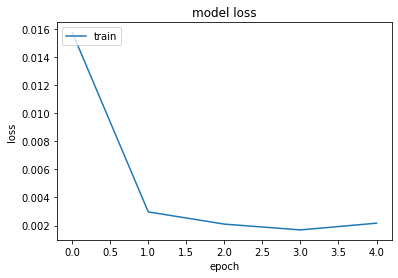

In [186]:
# Ploting Model History
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [187]:
# Create the testing data set
test_data = scaled_data[training_data_len - pred_days: , :]

# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]

for x in range(pred_days, len(test_data)):
    x_test.append(test_data[x-pred_days:x, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print (f'The mean squared error for price prediction is: {rmse} USD')

The mean squared error for price prediction is: 0.9653479176671242 USD


### 10. Final model price prediction plot

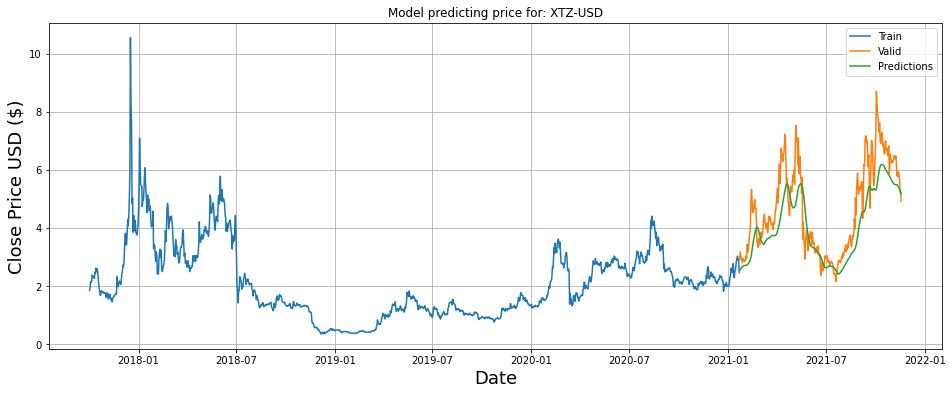

In [188]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# Visualize the data
plt.figure(figsize=(16,6))
plt.title(f'Model predicting price for: {coin}')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Valid', 'Predictions'], loc='best')
plt.grid()
plt.show()

In [189]:
# Show the last 10 days of price prediction
valid['Proc_Diff'] =1-(valid['Predictions']/valid['Close'])
valid.tail(10)

,Close,Predictions,Proc_Diff
Date,,,
2021-11-09,6.299470,5.490682,0.128390
2021-11-10,5.795598,5.488861,0.052926
2021-11-11,5.894379,5.468867,0.072189
2021-11-12,5.769511,5.441665,0.056824
2021-11-13,5.940872,5.405751,0.090074
2021-11-14,5.831571,5.371190,0.078946
2021-11-15,5.715568,5.334779,0.066623
2021-11-16,5.230594,5.295123,-0.012337
2021-11-17,5.224225,5.238986,-0.002826


## Predict next day price

In [190]:
# Use model to predict future coin price 

future_next_day =[test_data[len(test_data) - pred_days:len(test_data) + 1, 0]]
future_next_day = np.array(future_next_day)
future_next_day = np.reshape(future_next_day, (future_next_day.shape[0], future_next_day.shape[1], 1))

prediction = model.predict(future_next_day)
prediction = scaler.inverse_transform(prediction)
print(f'The price prediction on {(datetime.today() + timedelta(days=1)).date()} for: {coin} is {prediction} USD')
print('Above price is not financial advice it is just for fun :)')

The price prediction on 2021-11-19 for: XTZ-USD is [[5.0969563]] USD
Above price is not financial advice it is just for fun :)
